In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.7 MB/s eta 0:00:00


In [2]:
import os
import glob
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score
import torch.nn.functional as F
import shutil
from PIL import Image
import torchmetrics

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# %cd /content/gdrive/MyDrive/MODELS_DATA/ProjectData/ProjectData


In [ ]:
# !tar -xvzf lfw.tgz  &> /dev/null

In [5]:
POS_PATH = '/content/gdrive/MyDrive/MODELS_DATA/ProjectData/ProjectData/data/positive'
NEG_PATH = '/content/gdrive/MyDrive/MODELS_DATA/ProjectData/ProjectData/data/negative'
ANC_PATH = '/content/gdrive/MyDrive/MODELS_DATA/ProjectData/ProjectData/data/anchor'

In [6]:
lfw = "/content/gdrive/MyDrive/MODELS_DATA/ProjectData/ProjectData/lfw"

In [ ]:
# source_folder = '/content/gdrive/MyDrive/MODELS_DATA/ProjectData/ProjectData/lfw'
# destination_folder = '/content/gdrive/MyDrive/MODELS_DATA/ProjectData/ProjectData/data/negative'

In [ ]:
# for subdir, dirs, files in os.walk(source_folder):
#     for file in files:
#         filepath = subdir + os.sep + file
#         if filepath.endswith(".jpg") or filepath.endswith(".jpeg") or filepath.endswith(".png"):
#             shutil.move(filepath, destination_folder)

In [ ]:
# Import uuid library to generate unique image names
# import uuid

In [ ]:
# os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [19]:
# Collect Positive and Anchor Classes getting image directory

# define image transformations
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#file paths fort he anchor, positive, and negative images
anchor_paths = glob.glob(ANC_PATH + '/*.jpg')[:300]
positive_paths = glob.glob(POS_PATH + '/*.jpg')[:300]
negative_paths = glob.glob(NEG_PATH + '/*.jpg')[:300]

#custom dataset class for the siamse network
class SiameseDataset(Dataset):
    def __init__(self, anchor_paths, positive_paths, negative_paths, transform=None):
        self.anchor_paths = anchor_paths
        self.positive_paths = positive_paths
        self.negative_paths = negative_paths
        self.transform = transform

    def __len__(self):
        return len(self.anchor_paths)

    def __getitem__(self, idx):
      anchor_img = Image.open(self.anchor_paths[idx])
      if random.random() > 0.5:
        positive_img = Image.open(self.positive_paths[idx])
        label = 1
      else:
        negative_img = Image.open(self.negative_paths[idx])
        label = 0
      if self.transform:
        anchor_img = self.transform(anchor_img)
        positive_img = self.transform(positive_img) if label == 1 else self.transform(negative_img)
      return anchor_img, positive_img, torch.tensor(label, dtype=torch.float32)


#SiameseDataset class for the anchor, positive, and negative images

positive_dataset = SiameseDataset(anchor_paths, positive_paths, positive_paths, transform=transform)
negative_dataset = SiameseDataset(anchor_paths, negative_paths, negative_paths, transform=transform)

def preprocess_twin(input_img, validation_img, label):
    return (transform(input_img), transform(validation_img), label)

# Combineing the positive and negative datasets into a single dataset
dataset = torch.utils.data.ConcatDataset([positive_dataset, negative_dataset])

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

In [20]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 10)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 7)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 4096)
        self.sigmoid = nn.Sigmoid()

        self.classifier = nn.Linear(1, 1)

    def forward_once(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        
        return x
    
    def forward(self, input_image, validation_image):
      # passing the anchor and positive images through the network
      input_embedding = self.forward_once(input_image)
      validation_embedding = self.forward_once(validation_image)
    
      #calculating the L1 distance between the embeddings
      distances = torch.sum(torch.abs(input_embedding - validation_embedding), axis=1)
      distances = distances.view(-1, 1)  # Change the shape of distances to be a 2D tensor
    
      #classifying the pair as a match or mismatch
      classifier = self.classifier(distances)
      classifier = nn.Sigmoid()(classifier)
    
      return classifier.squeeze()


In [21]:
siamese_model = SiameseNetwork()
siamese_model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(siamese_model.parameters(),lr=0.0001)

num_epochs = 36

In [22]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
recalls = []
precisions = []

for epoch in range(num_epochs):
    running_loss = 0.0
    
    recall = torchmetrics.Recall(num_classes=2, average='macro', task='binary').to(device)
    precision = torchmetrics.Precision(num_classes=2, average='macro', task='binary').to(device)

    for i, (input_image, validation_image, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_image = input_image.to(device)
        validation_image = validation_image.to(device)
        labels = labels.to(device)
        outputs = siamese_model(input_image, validation_image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted = torch.round(outputs)
        recall.update(predicted.to("cpu"), labels.to("cpu"))
        precision.update(predicted.to("cpu"), labels.to("cpu"))
        
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for input_image, validation_image, labels in test_dataloader:
            input_image = input_image.to(device)
            validation_image = validation_image.to(device)
            labels = labels.to(device)
            outputs = siamese_model(input_image, validation_image)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()

    train_losses.append(running_loss/len(train_dataloader))
    train_accuracies.append(correct/total)
    test_losses.append(test_loss/len(test_dataloader))
    test_accuracies.append(correct/total)
    recalls.append(recall.compute())
    precisions.append(precision.compute())

    print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Recall: {recalls[-1]:.4f}, Precision: {precisions[-1]:.4f}")

print(f"Final Recall: {recalls[-1]:.4f}, Final Precision: {precisions[-1]:.4f}")

Epoch 1 - Train Loss: 1.1914, Test Loss: 0.8535, Recall: 1.0000, Precision: 0.4738
Epoch 2 - Train Loss: 0.8780, Test Loss: 0.7926, Recall: 1.0000, Precision: 0.4595
Epoch 3 - Train Loss: 0.7671, Test Loss: 0.7879, Recall: 1.0000, Precision: 0.5595
Epoch 4 - Train Loss: 0.7906, Test Loss: 0.8996, Recall: 1.0000, Precision: 0.5333
Epoch 5 - Train Loss: 0.8307, Test Loss: 0.8332, Recall: 1.0000, Precision: 0.4881
Epoch 6 - Train Loss: 0.8060, Test Loss: 0.8566, Recall: 1.0000, Precision: 0.5238
Epoch 7 - Train Loss: 0.8032, Test Loss: 0.8019, Recall: 1.0000, Precision: 0.5167
Epoch 8 - Train Loss: 0.7866, Test Loss: 0.8241, Recall: 1.0000, Precision: 0.5167
Epoch 9 - Train Loss: 0.8142, Test Loss: 0.7970, Recall: 1.0000, Precision: 0.4929
Epoch 10 - Train Loss: 0.7899, Test Loss: 0.8509, Recall: 1.0000, Precision: 0.5310
Epoch 11 - Train Loss: 0.8112, Test Loss: 0.8091, Recall: 1.0000, Precision: 0.4857
Epoch 12 - Train Loss: 0.7898, Test Loss: 0.7627, Recall: 1.0000, Precision: 0.5286
E

In [ ]:
predictions = siamese_model(input_image, validation_image)

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in predictions ]

[1, 0, 1, 1]


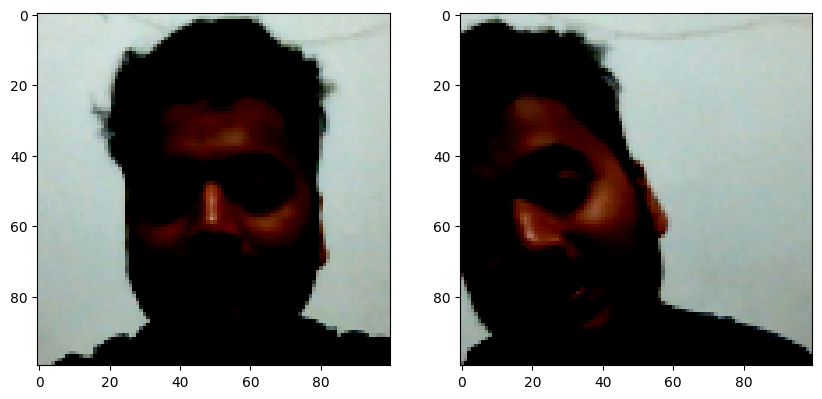

In [ ]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(input_image[0].cpu().permute(1, 2, 0))

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(validation_image[0].cpu().permute(1, 2, 0))

# Renders cleanly
plt.show()

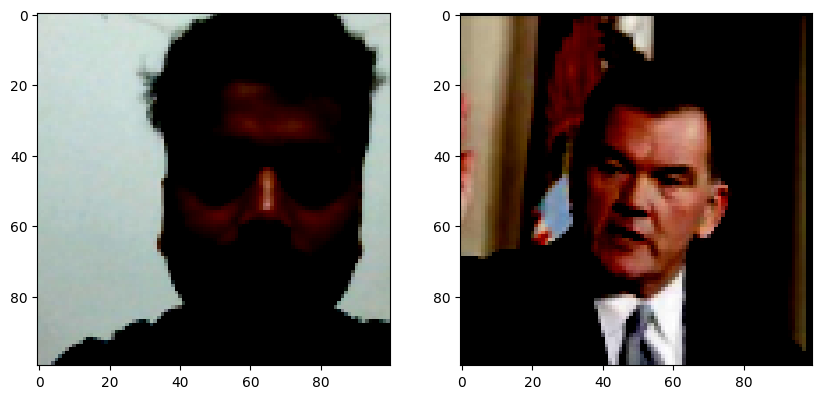

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(input_image[1].cpu().permute(1, 2, 0))

plt.subplot(1,2,2)
plt.imshow(validation_image[1].cpu().permute(1, 2, 0))

plt.show()

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')